In [3]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cuda:0].
CPU times: user 699 ms, sys: 294 ms, total: 993 ms
Wall time: 1.83 s


In [4]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 6.85 s, sys: 1.03 s, total: 7.88 s
Wall time: 9.58 s


In [5]:
class FactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(FactorizationMachine, self).__init__()
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        self.bias = nn.Parameter(torch.zeros((1, )))

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        square_sum = self.embed2(x).sum(dim=1).pow(2).sum(dim=1)
        sum_square = self.embed2(x).pow(2).sum(dim=1).sum(dim=1)
        output = self.embed1(x).squeeze(-1).sum(dim=1) + self.bias + (square_sum + sum_square) / 2
        output = torch.sigmoid(output).unsqueeze(-1)
        return output


class FactorizationMachineSupportedNeuralNetwork(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(FactorizationMachineSupportedNeuralNetwork, self).__init__()
        
        # w1, w2, ..., wn
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        
        # v1, v2, ..., vn
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        
        self.mlp = MultiLayerPerceptron([(embed_dim + 1)*len(field_dims), 128, 64, 32, 1]) 

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        
        w = self.embed1(x).squeeze(-1)
        v = self.embed2(x).reshape(x.shape[0], -1)
        stacked = torch.hstack([w, v])
        
        output = self.mlp(stacked)
        output = torch.sigmoid(output)
        return output


 24%|██▎       | 142/600 [00:10<00:33, 13.58it/s]


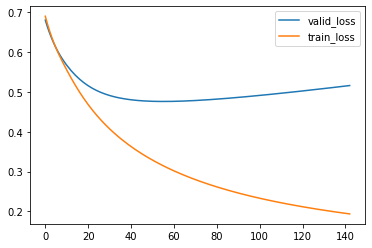

train_loss: 0.35309 | train_metric: 0.90839
valid_loss: 0.47912 | valid_metric: 0.74846
test_loss:  0.46753 | test_auc:  0.75777
CPU times: user 10.5 s, sys: 198 ms, total: 10.7 s
Wall time: 10.8 s


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

fm = FactorizationMachine(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(fm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(fm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))


 17%|█▋        | 103/600 [00:18<01:29,  5.52it/s]


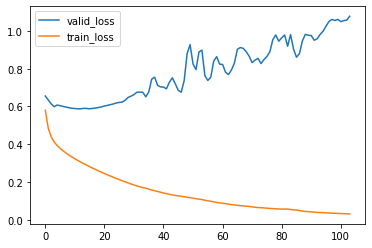

train_loss: 0.45483 | train_metric: 0.93952
valid_loss: 0.59880 | valid_metric: 0.72019
test_loss:  0.59387 | test_auc:  0.72644
CPU times: user 18.1 s, sys: 296 ms, total: 18.4 s
Wall time: 18.9 s


In [7]:
%%time

fnn = FactorizationMachineSupportedNeuralNetwork(field_dims, EMBEDDING_DIM).to(device)

# 参数赋值
fm_state_dict = fm.state_dict()
fnn_state_dict = fnn.state_dict()
fnn_state_dict['embed1.embedding.weight'] = fm_state_dict['embed1.embedding.weight']
fnn_state_dict['embed2.embedding.weight'] = fm_state_dict['embed2.embedding.weight']
fnn_state_dict['mlp.mlp.0.bias'] = torch.zeros_like(fnn_state_dict['mlp.mlp.0.bias']).fill_(fm_state_dict['bias'].item())
fnn.load_state_dict(fnn_state_dict)

optimizer = optim.Adam(fnn.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(fnn, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))


FNN 用了 FM 的参数后收敛确实更快，而且指标上相比不用的情况下也有所上升，但好像数据量少的情况下还是不如 FM。